In [1]:
import arviz as az
import numpy as np
import pandas as pd
from pathlib import Path
import pymc as pm

In [2]:
trace_path = Path("D:/MattReda/FairlifeSearch/search_model/trace_with_holiday_linspline_no_shopper_lognormal_everywhere.nc")

In [3]:
with pm.Model() as model:
    K_m = pm.Normal("K_m", mu=np.log(.9), sigma=np.log(1.6))
    #K = pm.TruncatedNormal(
    #  "K_impressions", 
    #  mu=K_m, 
    #  sigma=.01, 
    #  lower=.2, 
    #  dims=("outlet", "campaign", "media")
    #  )
    
    n_m = pm.TruncatedNormal("n_m", mu=np.log(1.2), sigma=np.log(1.4), lower=np.log(.8))

K_m_sample, n_m_sample = pm.draw([K_m, n_m], (4000))

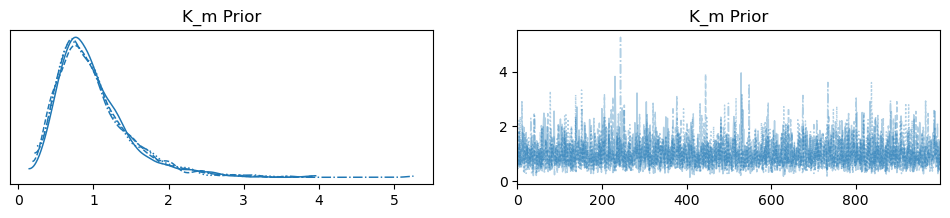

In [7]:
axss = az.plot_trace(np.exp(K_m_sample.reshape(4, 1000, 1)))
for axs in axss:
    for ax in axs:
        ax.set_title("K_m Prior")

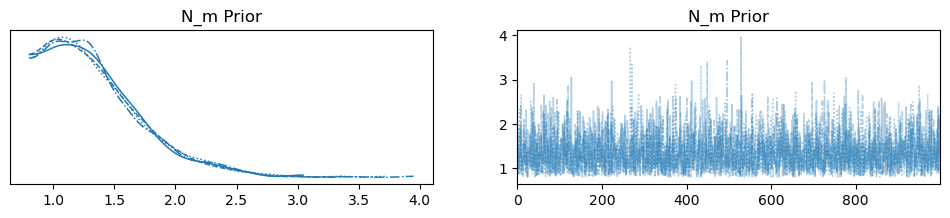

In [8]:
axss = az.plot_trace(np.exp(n_m_sample.reshape(4, 1000, 1)))
for axs in axss:
    for ax in axs:
        ax.set_title("N_m Prior")

In [3]:
trace = az.from_netcdf(trace_path)

In [7]:
def hill(x, K_m, n):
    x_t = x[None, None, None, :]
    return x_t**n[..., None]/(x_t**n[..., None]+K_m[..., None]**n[..., None])

In [54]:
trace.posterior["Impression Model::betas_media_mu_log"]

<xarray.DataArray 'Impression Model::betas_media_mu_log' (chain: 4, draw: 1000,
                                                          media: 8)> Size: 256kB
[32000 values with dtype=float64]
Coordinates:
  * chain    (chain) int32 16B 0 1 2 3
  * draw     (draw) int32 4kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * media    (media) <U16 512B 'AUDIO' 'DISPLAY' 'ECOM' ... 'OTT' 'SOCIAL'

In [55]:
hill_x = hill(np.linspace(0, 3, 100), np.exp(trace.posterior["Impression Model::K_m"].values), np.exp(trace.posterior['Impression Model::n_m'].values))*np.exp(trace.posterior['Impression Model::betas_media_mu_log'].values[:, :, :, None])
x = np.linspace(0, 3, 100)

In [56]:
import matplotlib.pyplot as plt

In [57]:
np.quantile(hill_x, [.2, .8], axis=(0, 1)).shape

(2, 8, 100)

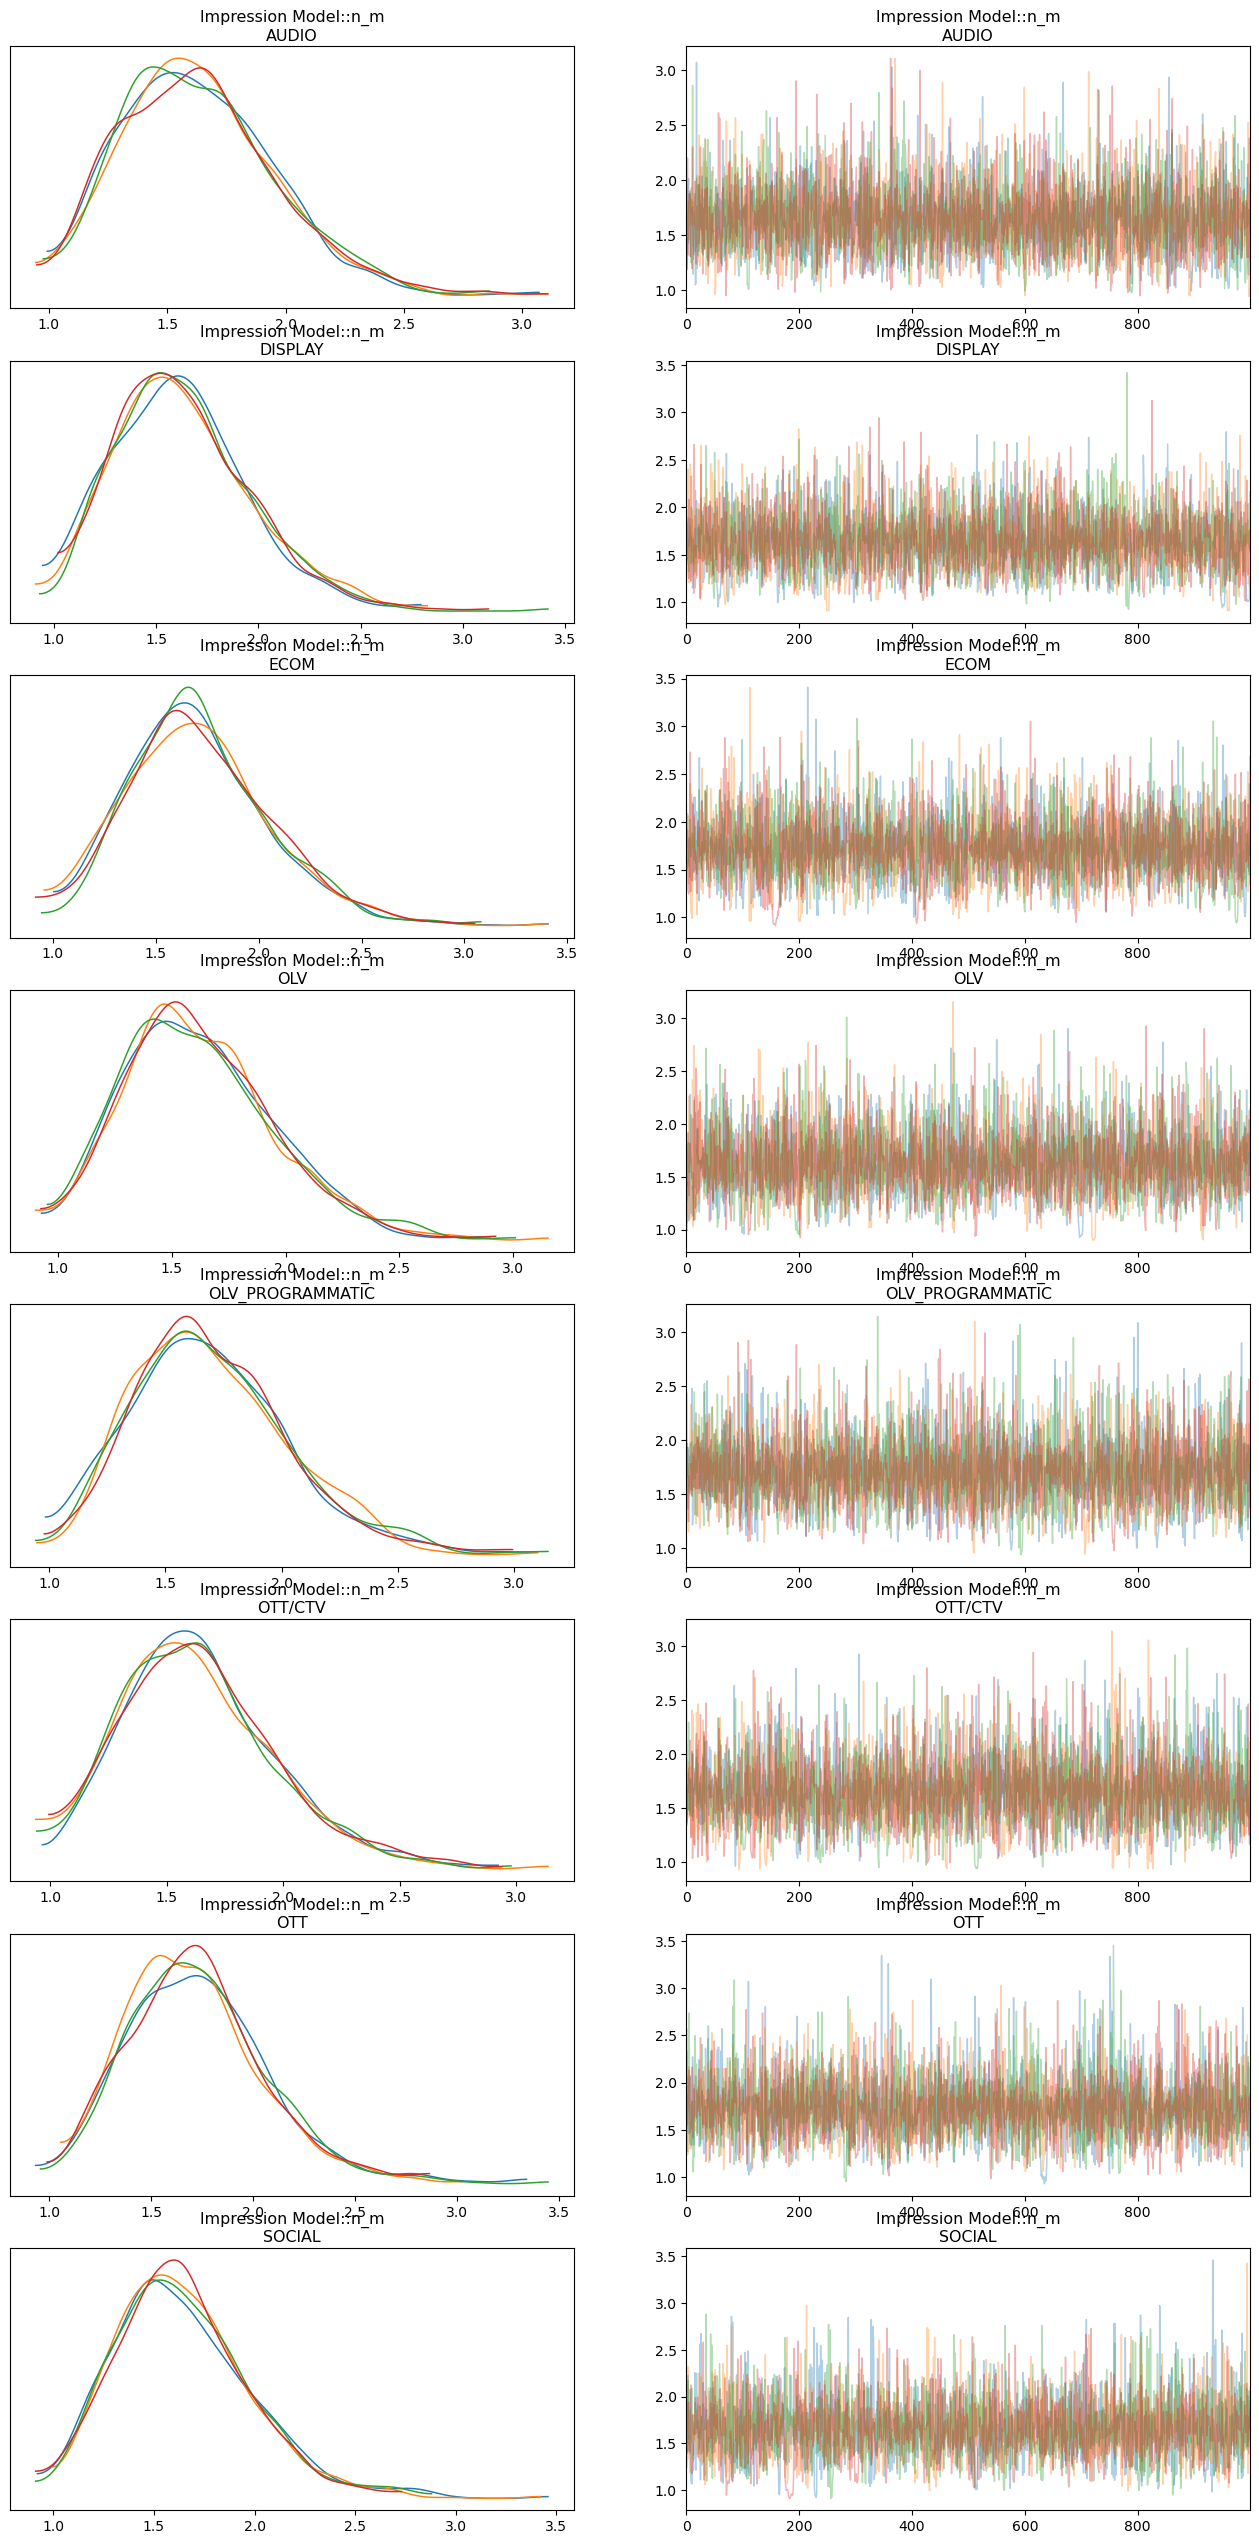

In [72]:
az.plot_trace(np.exp(trace.posterior[["Impression Model::n_m"]]), figsize=(16, 4*8), compact=False);


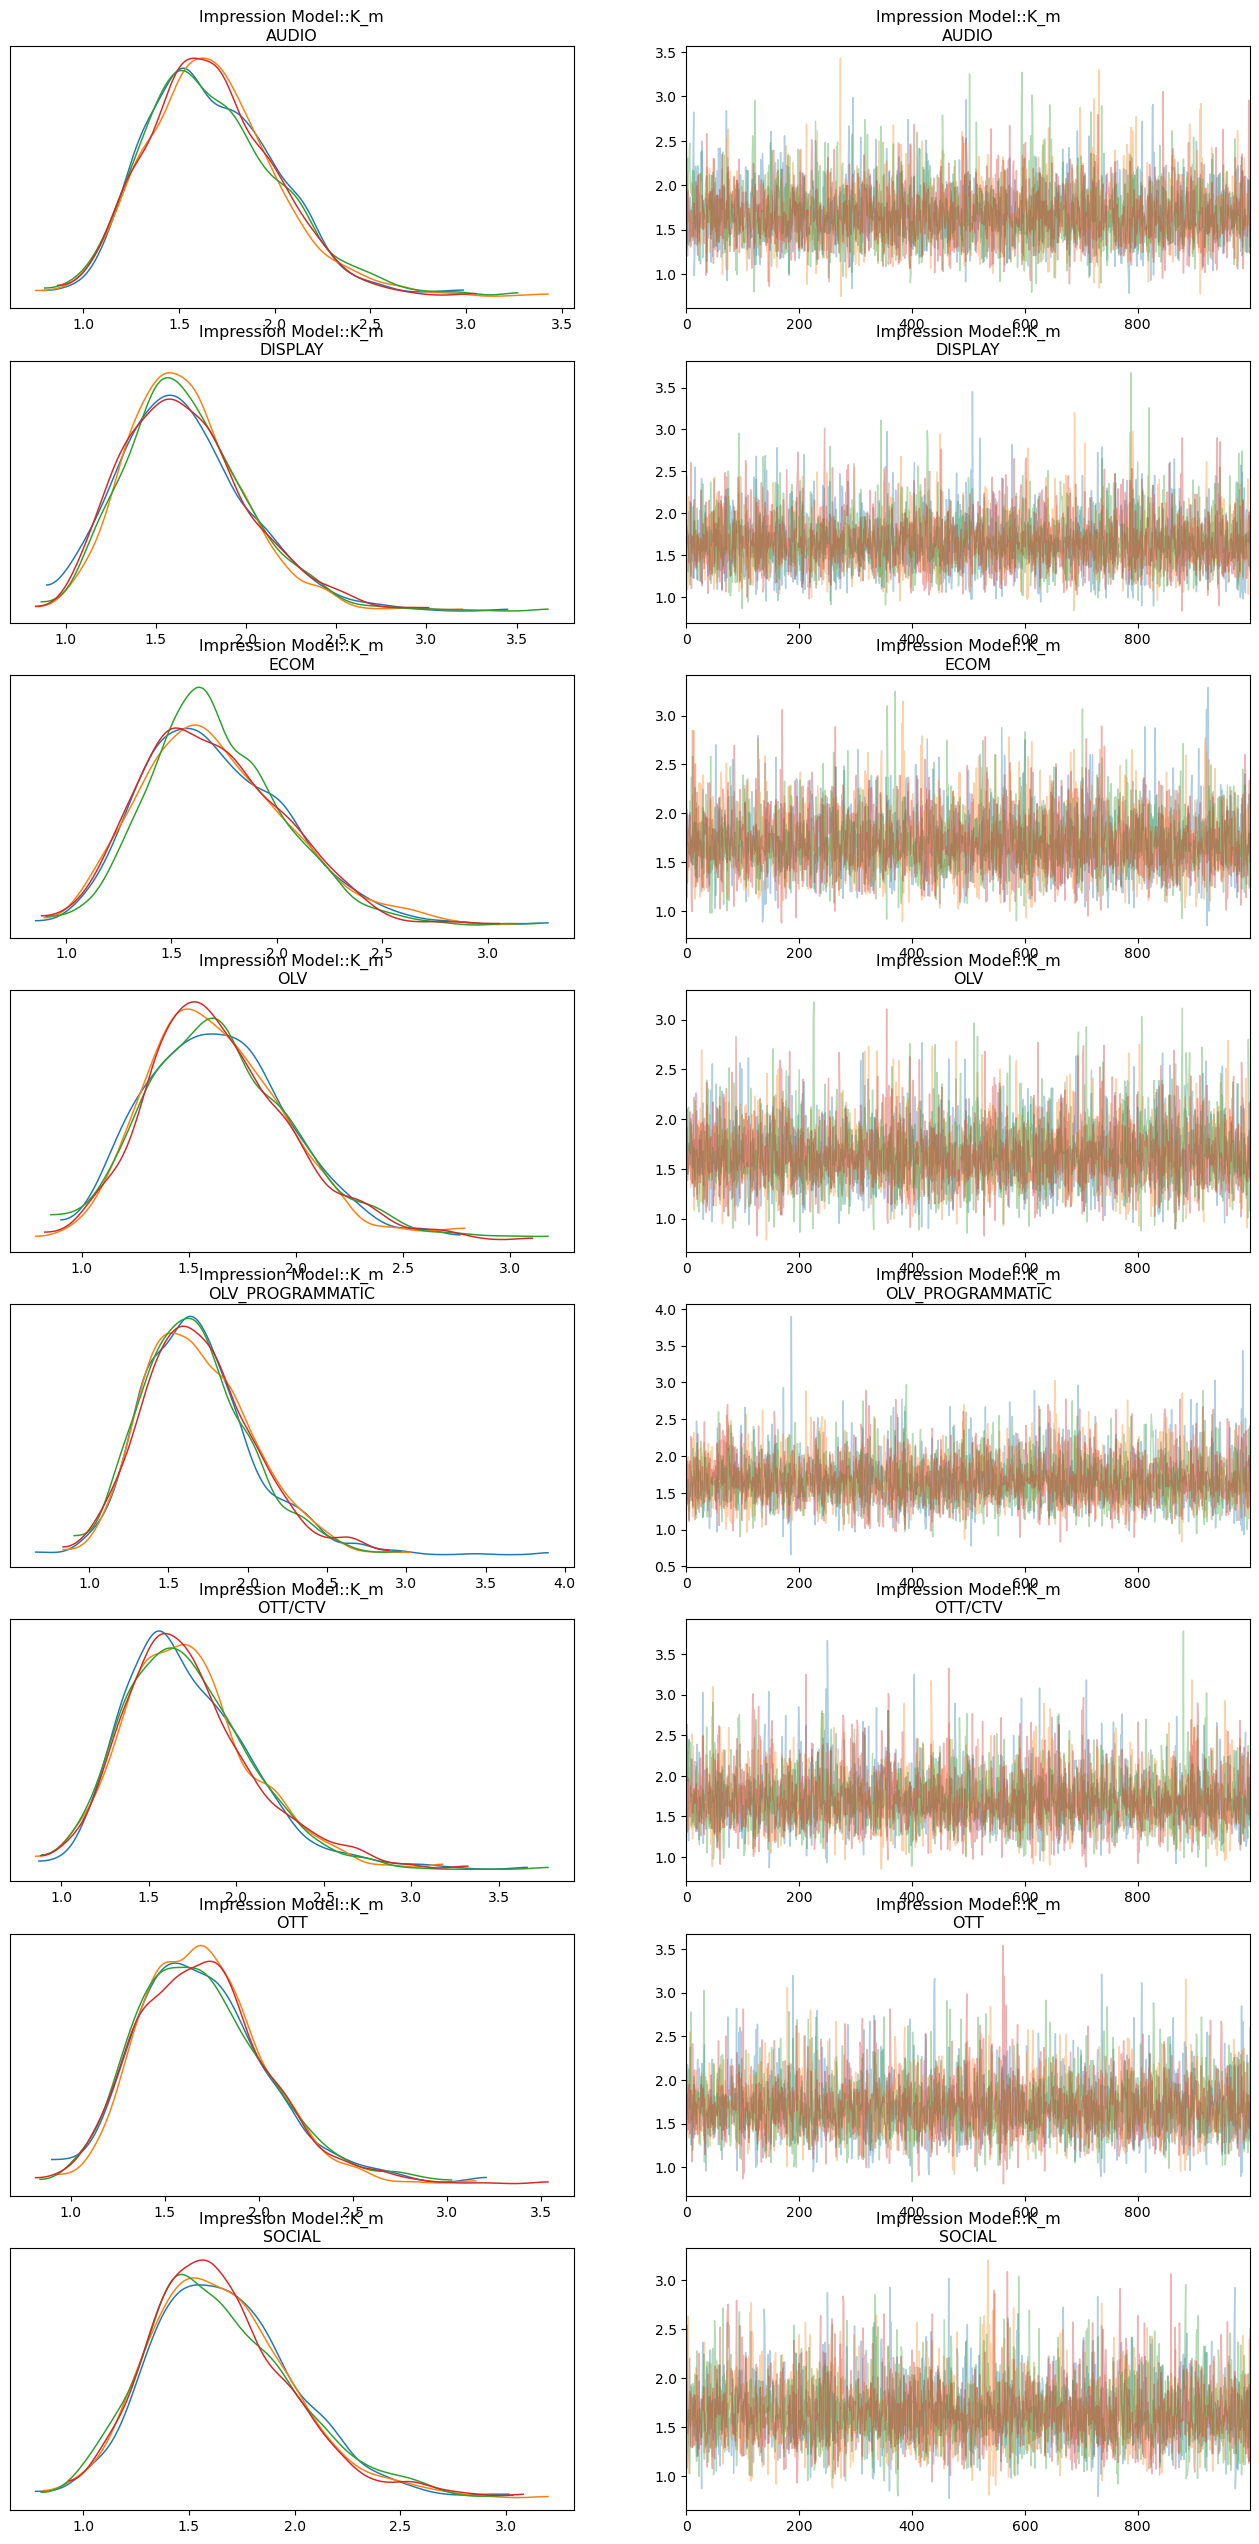

In [71]:
az.plot_trace(np.exp(trace.posterior[["Impression Model::K_m"]]), figsize=(16, 4*8), compact=False);


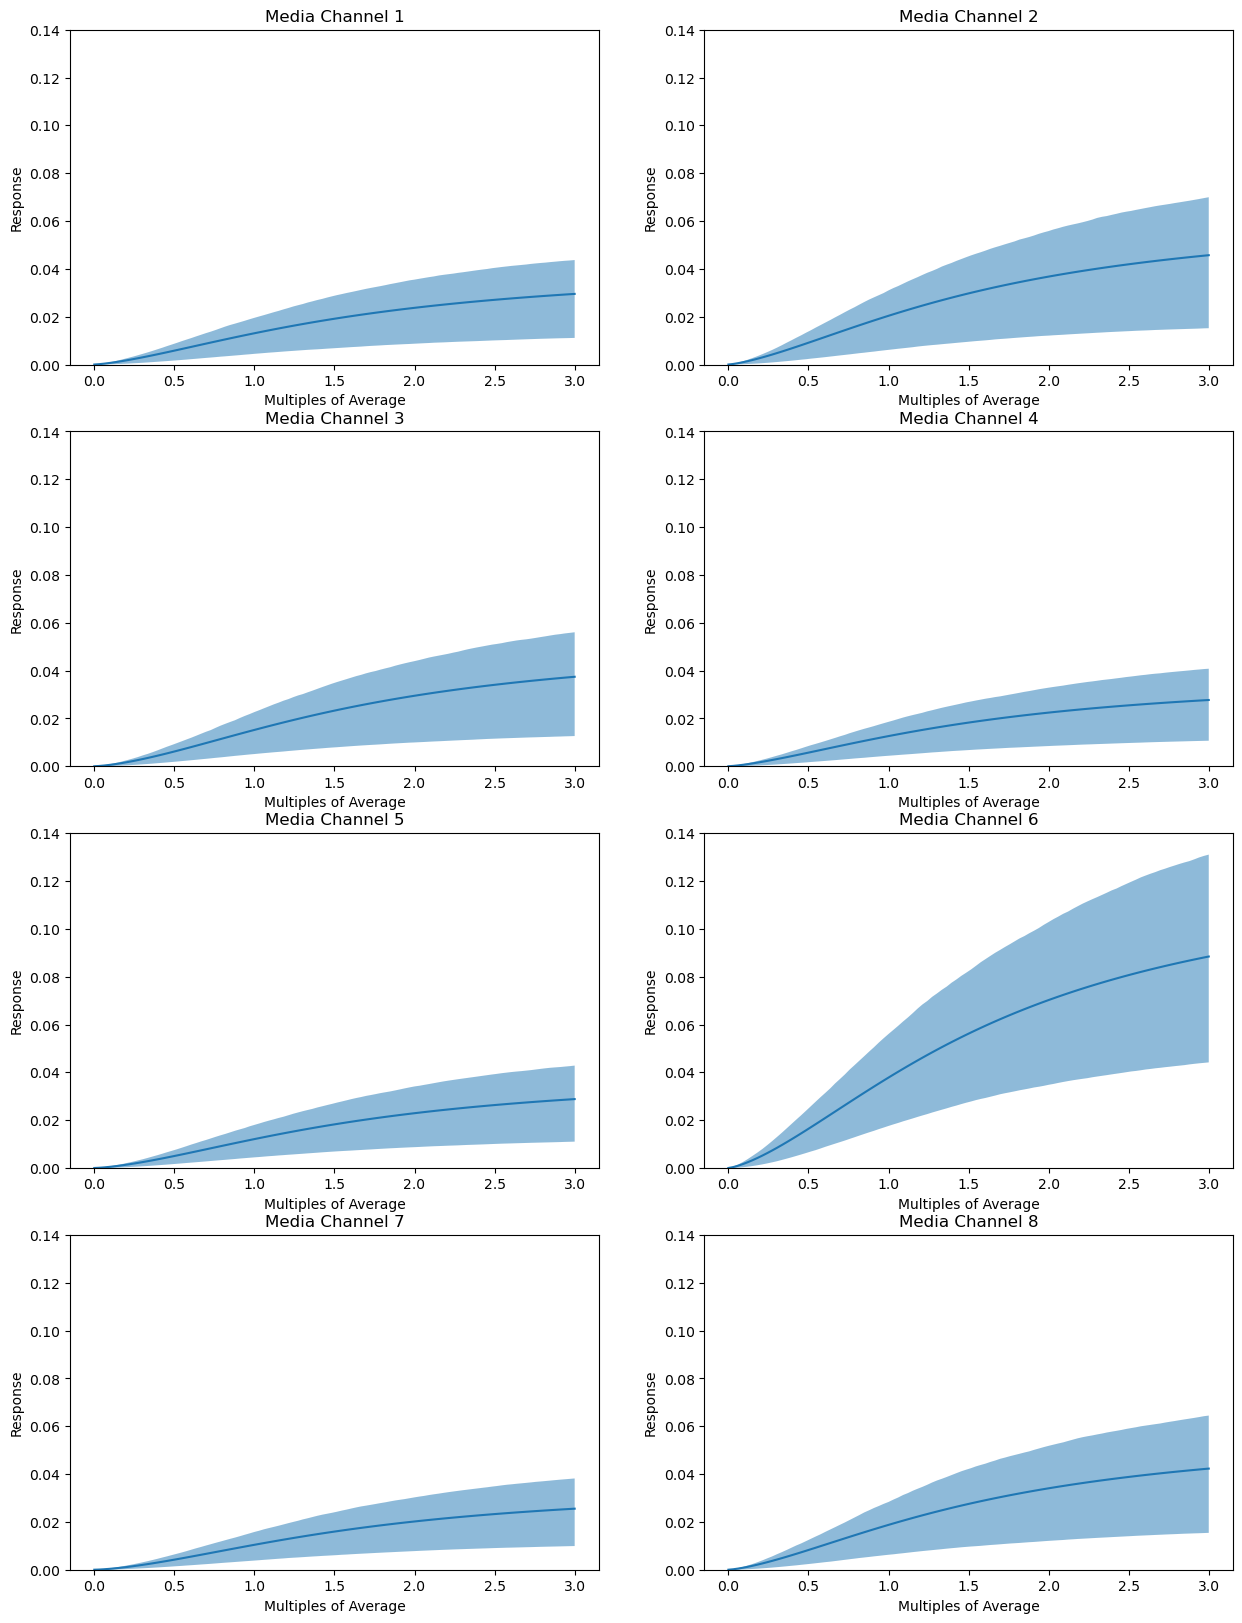

In [58]:
hdi_89 = np.quantile(hill_x, [.2, .8], axis=(0, 1))
fig, ax = plt.subplots(4, 2, figsize=(15, 20))
for channel in range(8):
    ax_ = ax[channel//2, channel%2]
    ax_.plot(x, np.mean(hill_x, axis=(0, 1))[channel, :])
    ax_.fill_between(x, hdi_89[0, channel, :], hdi_89[1, channel, :], alpha=.5)
    ax_.set_ylim(0, .14)
    ax_.set_ylabel("Response")
    ax_.set_xlabel("Multiples of Average")
    ax_.set_title(f"Media Channel {channel+1}")

In [4]:
media_effect = trace.posterior["Impression Model::media_effect"]

In [5]:
median_media_effect = np.exp(media_effect).quantile([.05, .5, .95], dim=("chain", "draw"))

In [6]:
median_media_effect

<xarray.DataArray 'Impression Model::media_effect' (quantile: 3, date: 156,
                                                    outlet: 2, campaign: 2,
                                                    media: 8)> Size: 120kB
array([[[[[1.00000048, 1.00000116, 1.00000078, ..., 1.        ,
           1.0000001 , 1.        ],
          [1.00000046, 1.00000119, 1.00000077, ..., 1.        ,
           1.0000001 , 1.        ]],

         [[1.00000049, 1.00000124, 1.00000079, ..., 1.        ,
           1.0000001 , 1.        ],
          [1.00000049, 1.00000114, 1.00000081, ..., 1.        ,
           1.00000011, 1.        ]]],


        [[[1.00058986, 1.0011808 , 1.00161481, ..., 1.        ,
           1.00010724, 1.00000006],
          [1.00058392, 1.00119093, 1.00162556, ..., 1.        ,
           1.000112  , 1.00000006]],

         [[1.00059304, 1.00120456, 1.00158236, ..., 1.        ,
           1.00010994, 1.00000006],
          [1.00060008, 1.00117613, 1.00158402, ..., 1.        ,
           1.00011243, 1.00000006]]],
...
        [[[1.013135  , 1.07201173, 1.00032682, ..., 1.        ,
           1.02424494, 1.03540761],
          [1.01286398, 1.07355518, 1.00031824, ..., 1.        ,
           1.02469848, 1.03595124]],

         [[1.01302115, 1.07157169, 1.00032143, ..., 1.        ,
           1.02470862, 1.03540978],
          [1.01308819, 1.07377473, 1.00032692, ..., 1.        ,
           1.02468266, 1.03636661]]],


        [[[1.01270079, 1.06635255, 1.02791356, ..., 1.        ,
           1.0014018 , 1.05798722],
          [1.01248975, 1.06870595, 1.02781146, ..., 1.        ,
           1.00147592, 1.06026392]],

         [[1.01272193, 1.06630855, 1.02796015, ..., 1.        ,
           1.00140065, 1.05911814],
          [1.01274192, 1.0674483 , 1.02883714, ..., 1.        ,
           1.00139856, 1.06058654]]]]])
Coordinates:
  * media     (media) <U16 512B 'AUDIO' 'DISPLAY' 'ECOM' ... 'OTT' 'SOCIAL'
  * outlet    (outlet) <U6 48B 'BING' 'GOOGLE'
  * campaign  (campaign) <U9 72B 'BRANDED' 'UNBRANDED'
  * date      (date) datetime64[ns] 1kB 2020-12-28 2021-01-04 ... 2023-12-18
  * quantile  (quantile) float64 24B 0.05 0.5 0.95

In [7]:
media_effect_df = (median_media_effect.to_dataframe()).reset_index()
media_effect_df.head()

,quantile,date,outlet,campaign,media,Impression Model::media_effect
0,0.05,2020-12-28,BING,BRANDED,AUDIO,1.000000
1,0.05,2020-12-28,BING,BRANDED,DISPLAY,1.000001
2,0.05,2020-12-28,BING,BRANDED,ECOM,1.000001
3,0.05,2020-12-28,BING,BRANDED,OLV,1.000000
4,0.05,2020-12-28,BING,BRANDED,OLV_PROGRAMMATIC,1.000000


In [8]:
media_effect_pivoted = (media_effect_df.pivot(index=("date", 'quantile', 'outlet', 'campaign'), columns=['media'], values="Impression Model::media_effect") -1)

In [9]:
media_effect_pivoted.reset_index().to_csv("LinMediaEffectNoShopper.csv", index=False)

In [10]:
search_data = trace.constant_data['search_impressions'].to_dataframe()

In [11]:
search_data = search_data#/(search_data.reset_index().groupby("date")[['search_impressions']].sum())

In [12]:
search_data_ind = search_data.reset_index()

In [13]:
media_effect_pivoted_ind = media_effect_pivoted.reset_index()
merged_effects = media_effect_pivoted_ind.merge(search_data, on=['date', 'outlet', 'campaign'], how='left')

In [15]:
MEDIA_CHANNELS = ["AUDIO", "DISPLAY", "ECOM", "OLV", "OLV_PROGRAMMATIC", "OTT", 'OTT/CTV']#, "SHOPPER"]
media_contributions = merged_effects[MEDIA_CHANNELS].values * merged_effects[['search_impressions']].values
merged_effects[[channel+"_contribution" for channel in MEDIA_CHANNELS]] = media_contributions

In [16]:
merged_effects.to_csv("media_contributions.csv", index=False)